In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src.SavingFeedback import SavingFeedback
from src import crs, PublicPredictor
from src.dbc import utils, TimeDivisionKMeans
from src.PublicPredictor import get_col_list, get_step
import src.utils as ut

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

# SavingFeedback Init

ECV : 51 %
이상패턴 조정 확인 True


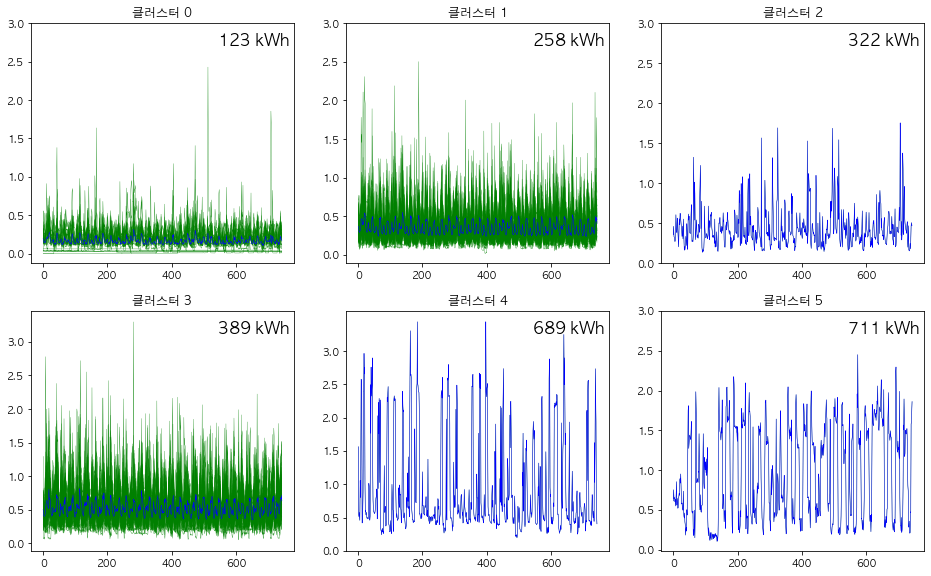

In [4]:
# 1. Data Pre-processing
sv = SavingFeedback(xlsx)
sv.select_month(1)

# 2. KMeans Run
sv.kmeans_run()

# 3. adjust anomaly
sv.adjust_anomaly()
anomaly = sv.check_anomaly()
print("이상패턴 조정 확인", len(anomaly) == 0)

sv.kmeans.draw_plot()

# Time Feedback

In [15]:
time_size = 3

sv.time_based_grouping(time_size)
sv.feedback()
sv.result()

time_group = sv.new_group.copy()
time_group.head()

round(time_group['usage (kWh)'].mean())

234

In [16]:
sv.recovery()

og_pat = sv.datas.values.T
rec_pat = sv.recoveries
err = (og_pat - rec_pat)
err[err != 0].min()

print(og_pat.shape, rec_pat.shape)
print("최소 오차", err[err != 0].min())

(108, 744) (108, 744)
최소 오차 0.0009999999999998899


In [66]:
err_chk = sv.group['usage (kWh)'] - time_group['usage (kWh)']

sv.group['name'][np.array(err_chk[err_chk != 0]).argmin()]

'아파트1-103-502'

In [71]:
time_group.iloc[10]

name           아파트1-103-502
usage (kWh)             153
label                     1
Name: 10, dtype: object

가구 명 : 아파트1-103-502


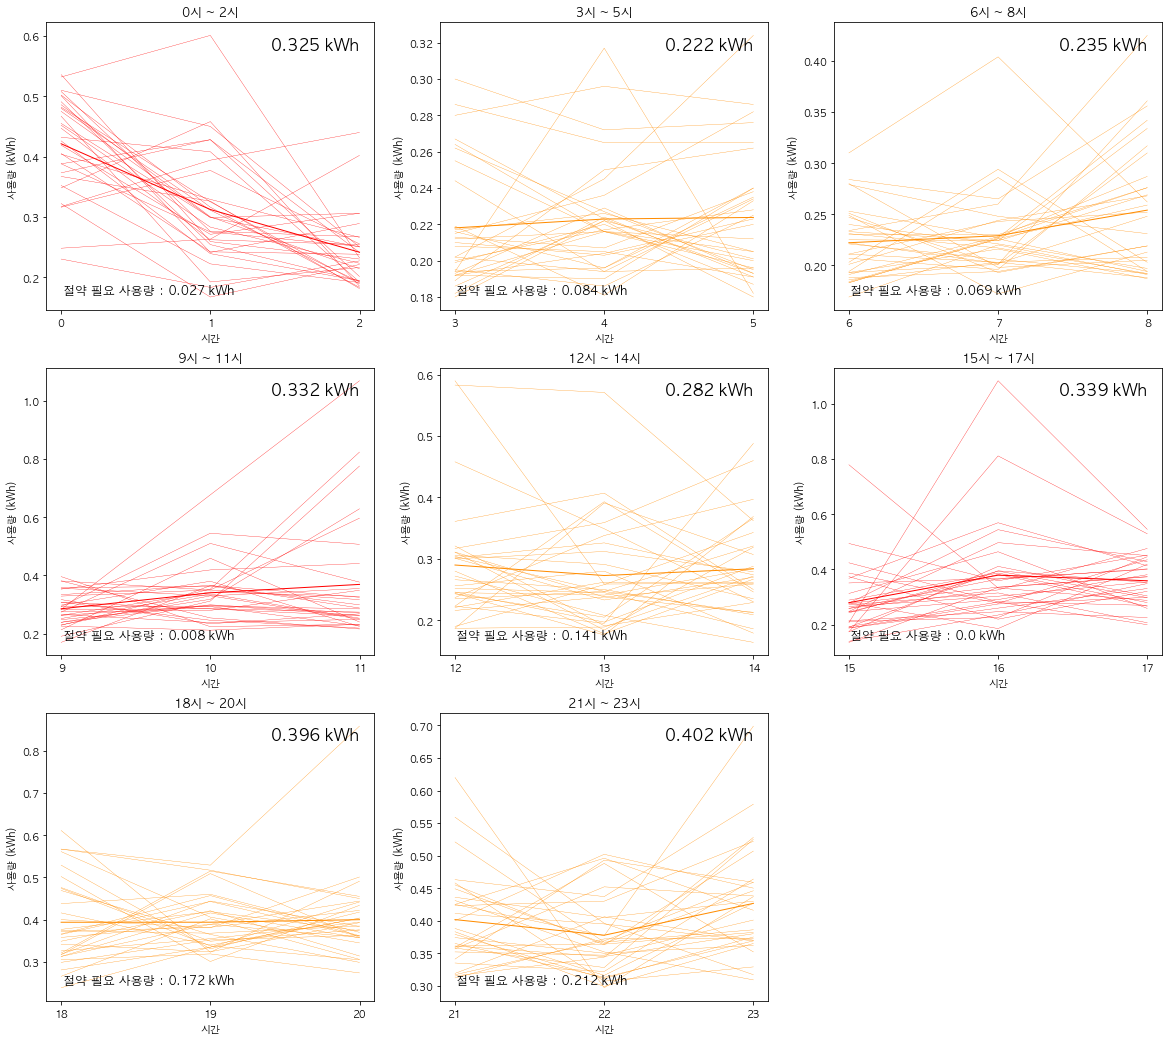

In [67]:
draw = sv.draw_init('아파트1-103-502')

draw.house()

현재 가구가 속해 있는 기여도 1번 그룹


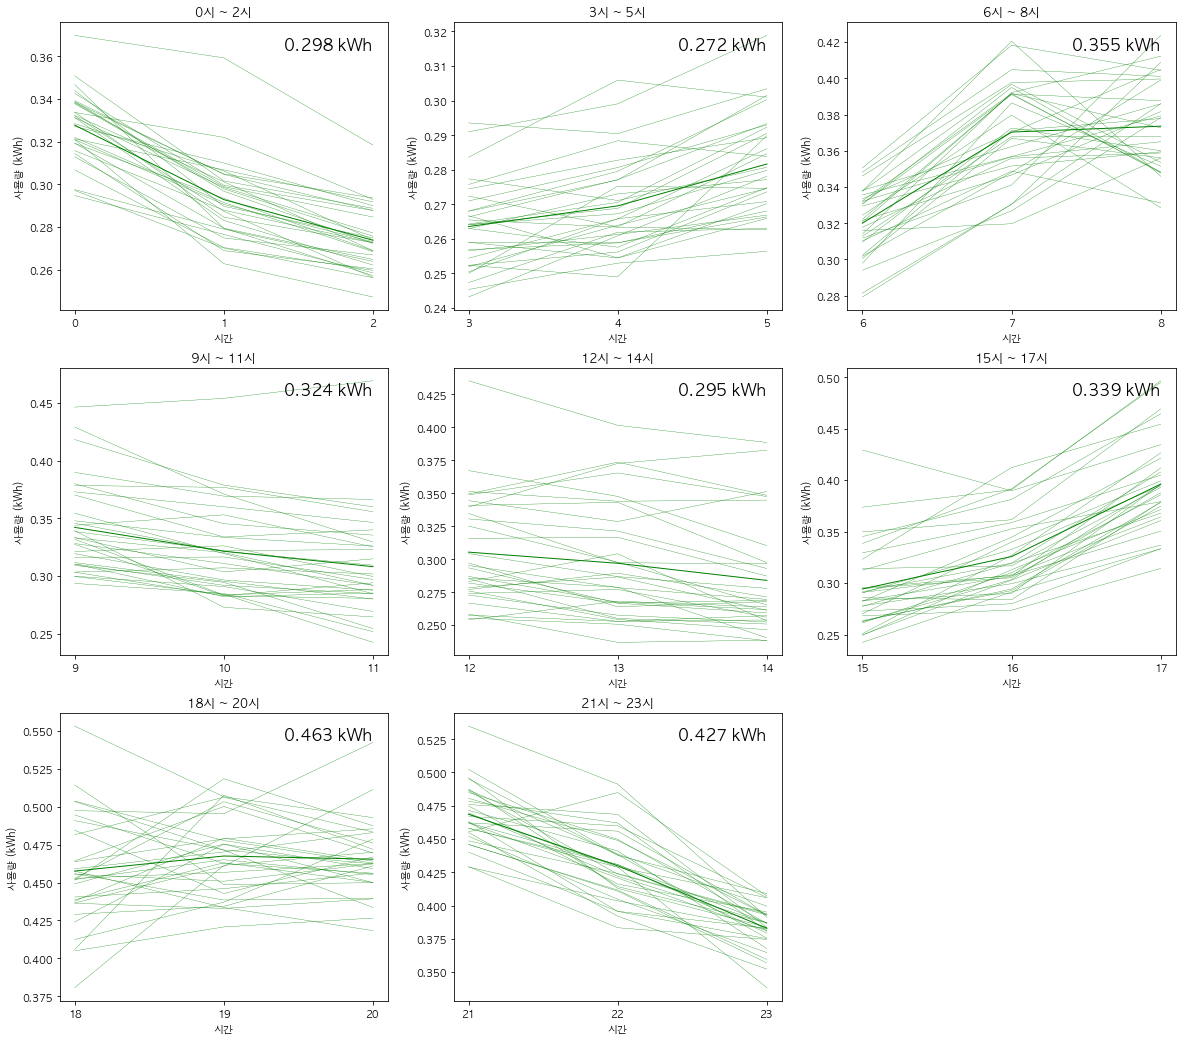

In [73]:
draw.now()

# Day Feedback

In [11]:
sv.day_based_grouping()
sv.feedback()
sv.result()

day_group = sv.new_group.copy()
day_group.head()

round(day_group['usage (kWh)'].mean())

264

# Compare
## Time

In [198]:
month = 1

before_month_df = month_df[['name', 'usage (kWh)']].copy()
after_month_df = time_group[['name', 'usage (kWh)']].copy()
house_count = len(before_month_df)

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)
public_kWh = APT - before_month_df['usage (kWh)'].sum()
before_calc = crs.models.ManagementOffice(
        month=month,
        households=before_month_df,
        APT=APT,
        contract="단일계약"
    )

after_APT = after_month_df['usage (kWh)'].sum() + public_kWh
after_calc = crs.models.ManagementOffice(
        month=month,
        households=after_month_df,
        APT=after_APT,
        contract="단일계약"
    )

compare_df = pd.DataFrame()
compare_df.index = ['before', 'after']
compare_df['APT 평균 사용량'] = [before_calc.apart.kwh, after_calc.apart.kwh]
compare_df['세대부 평균 사용량'] = [round(before_month_df['usage (kWh)'].mean()),
                           round(after_month_df['usage (kWh)'].mean())]
compare_df['공용부 평균 사용량'] = [
    round(public_kWh / house_count),
    round(public_kWh / house_count)
]

compare_df['아파트 전체 요금'] = [
    before_calc.bill,
    after_calc.bill
]
compare_df['세대부 전체 요금'] = [
    before_calc.bill - before_calc.public_bill,
    after_calc.bill - after_calc.public_bill
]
compare_df['공용부 요금'] = [
    before_calc.public_bill,
    after_calc.public_bill
]

compare_df.loc['error'] = compare_df.loc['before'] - compare_df.loc['after']
compare_df

,APT 평균 사용량,세대부 평균 사용량,공용부 평균 사용량,아파트 전체 요금,세대부 전체 요금,공용부 요금
before,411,288,123,6439540,3798980,2640560
after,282,159,123,3467260,1341320,2125940
error,129,129,0,2972280,2457660,514620


## Day

In [89]:
month = 1

before_month_df = sv.group[['name', 'usage (kWh)']].copy()
after_month_df = day_group[['name', 'usage (kWh)']].copy()
house_count = len(before_month_df)

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)
public_kWh = APT - before_month_df['usage (kWh)'].sum()
before_calc = crs.models.ManagementOffice(
        month=month,
        households=before_month_df,
        APT=APT,
        contract="단일계약"
    )

after_APT = after_month_df['usage (kWh)'].sum() + public_kWh
after_calc = crs.models.ManagementOffice(
        month=month,
        households=after_month_df,
        APT=after_APT,
        contract="단일계약"
    )

compare_df = pd.DataFrame()
compare_df.index = ['before', 'after']
compare_df['APT 평균 사용량'] = [before_calc.apart.kwh, after_calc.apart.kwh]
compare_df['세대부 평균 사용량'] = [round(before_month_df['usage (kWh)'].mean()),
                           round(after_month_df['usage (kWh)'].mean())]
compare_df['공용부 평균 사용량'] = [
    round(public_kWh / house_count),
    round(public_kWh / house_count)
]

compare_df['아파트 전체 요금'] = [
    before_calc.bill,
    after_calc.bill
]
compare_df['세대부 전체 요금'] = [
    before_calc.bill - before_calc.public_bill,
    after_calc.bill - after_calc.public_bill
]
compare_df['공용부 요금'] = [
    before_calc.public_bill,
    after_calc.public_bill
]

compare_df.loc['error'] = compare_df.loc['before'] - compare_df.loc['after']
compare_df

,APT 평균 사용량,세대부 평균 사용량,공용부 평균 사용량,아파트 전체 요금,세대부 전체 요금,공용부 요금
before,411,288,123,6439540,3798980,2640560
after,387,264,123,5331790,3222450,2109340
error,24,24,0,1107750,576530,531220


In [199]:
# 예측 시뮬레이션
pp = PublicPredictor(
    APT=after_APT,
    month_df=after_month_df,
    month=month
)

pp.predict

실제 요금    2125940
예측 요금    2125010
오차           930
dtype: int64

In [200]:
pp.basic * 108

5502600

In [201]:
crs.utils.print_apt_info(month, before_month_df, APT)

hh, anal = crs.utils.get_analysis_df(month, before_month_df, APT)
anal = anal[anal.columns[:-1]]
anal['최종청구금액'] = anal.sum(axis=1).astype('int')
anal.head()

APT : 44,434kWh (평균 사용량: 411kWh)
		6,439,540원
세대부 : 31,104kWh (70%) (평균 사용량: 288kWh)
		3,798,980원
공용부 : 13,330kWh (30%) (평균 사용량: 123kWh)
		2,640,560원


,기본요금,전력량요금,기후환경요금,연료비 조정액,VAT,전력산업기반기금,최종청구금액
APT,654480,4907088,235224,-133164,566363,209550,6439541
세대부,197480,3118820,164805,-93312,334205,123150,3845148
공용부,457000,1788268,70419,-39852,232158,86400,2594393
세대부 / APT percentage,30,64,70,70,59,59,352
공용부 / APT percentage,70,36,30,30,41,41,248


In [202]:
crs.utils.print_apt_info(month, after_month_df, after_APT)

hh, anal = crs.utils.get_analysis_df(month, after_month_df, after_APT)
anal = anal[anal.columns[:-1]]
anal['최종청구금액'] = anal.sum(axis=1).astype('int')
anal.head()

APT : 30,490kWh (평균 사용량: 282kWh)
		3,467,260원
세대부 : 17,160kWh (56%) (평균 사용량: 159kWh)
		1,341,320원
공용부 : 13,330kWh (44%) (평균 사용량: 123kWh)
		2,125,940원


,기본요금,전력량요금,기후환경요금,연료비 조정액,VAT,전력산업기반기금,최종청구금액
APT,136080,2843424,161352,-91368,304949,112830,3467267
세대부,87320,1279579,90895,-51480,118065,43120,1567499
공용부,48760,1563845,70457,-39888,186884,69710,1899768
세대부 / APT percentage,64,45,56,56,39,38,298
공용부 / APT percentage,36,55,44,44,61,62,302


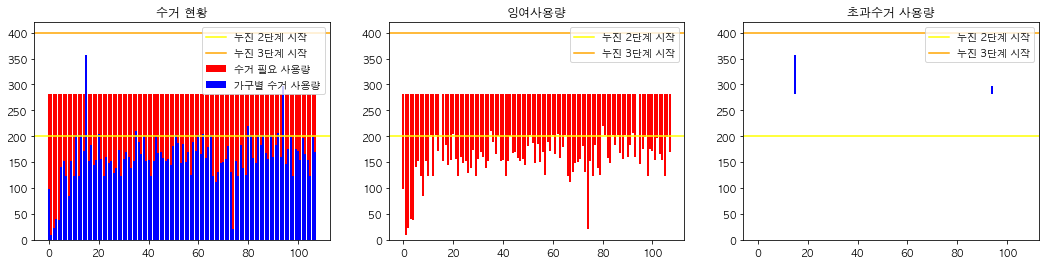

In [203]:
plt.figure(figsize=(18,4))

# 수거현황
ax_1 = plt.subplot(1,3,1)

ax_1.bar(range(0, len(month_df)), round(after_APT / 108), color='r')
ax_1.bar(range(0, len(month_df)), after_month_df['usage (kWh)'], color='b')

ax_1.axhline(200, color='yellow')
ax_1.axhline(400, color='orange')

ax_1.set_title("수거 현황")
ax_1.legend(["누진 2단계 시작","누진 3단계 시작",'수거 필요 사용량', '가구별 수거 사용량'], loc='upper right')

# 잉여사용량
ax_2 = plt.subplot(1,3,2)

ax_2.bar(range(0, len(month_df)), round(after_APT / 108), color='r')
ax_2.bar(range(0, len(month_df)), after_month_df['usage (kWh)'], color='white')

ax_2.axhline(200, color='yellow')
ax_2.axhline(400, color='orange')
ax_2.legend(["누진 2단계 시작","누진 3단계 시작"], loc='upper right')

ax_2.set_title("잉여사용량")

# 초과수거 사용량
ax_3 = plt.subplot(1,3,3)

ax_3.bar(range(0, len(month_df)), after_month_df['usage (kWh)'], color='b')
ax_3.bar(range(0, len(month_df)), round(after_APT / 108), color='white')

ax_3.axhline(200, color='yellow')
ax_3.axhline(400, color='orange')
ax_3.legend(["누진 2단계 시작","누진 3단계 시작"], loc='upper right')

ax_3.set_title("초과수거 사용량")

plt.show()

In [204]:
all_col_needed = np.array(get_col_list(round(after_APT / 108), calc.fee)) * len(month_df)
col_households = np.array([get_col_list(usage, calc.fee) for usage in after_month_df['usage (kWh)']]).sum(axis=0)

col_needed = np.array(get_col_list(round(after_APT / 108), calc.fee))
surplus_col = np.zeros(3)
excess_col = np.zeros(3)

for usage in after_month_df['usage (kWh)']:
    col_chk = col_needed - get_col_list(usage, calc.fee)
    
    for idx, chk in enumerate(col_chk):
        if chk > 0:
            surplus_col[idx] += chk
        else:
            excess_col[idx] += abs(chk)
            
pd.DataFrame(np.array([all_col_needed, col_households,
         surplus_col, excess_col]).reshape(-1, 3).astype("int"), columns=['누진 1단계', '누진 2단계', '누진 3단계'],
            index=['수거 필요 사용량',' 수거 사용량', '잉여 사용량', '초과수거 사용량'])

,누진 1단계,누진 2단계,누진 3단계
수거 필요 사용량,21600,8856,0
수거 사용량,16844,316,0
잉여 사용량,4756,8629,0
초과수거 사용량,0,89,0


In [205]:
round(after_APT / 108)

282

In [206]:
def get_col_list(kWh, fee):
    col_list = list()
    _usage = kWh
    for step, _f in enumerate(fee):
        collect_rate = _f[1] - _f[0]

        # 2단계일 경우
        if step == 1:
            collect_rate += 1

        if kWh < _f[1]:
            if (step == 0) or (step == 1):
                _col = _usage % collect_rate
            else:
                _col = _usage
        else:
            _col = collect_rate

        if _usage == 0:
            col_list.append(0)
        else:
            col_list.append(_col)
            _usage -= _col

    return np.array(col_list)

def get_step_mem(col_list, fee):
    _mem = list()
    _mem_step = 0
    
    for step,val in enumerate(col_list):
        _val = val
        f = fee[step][3]
        
        while _val != 0:
            _mem_step += f
            _mem.append(_mem_step)
            _val -= 1
            
            
    return np.array(_mem)

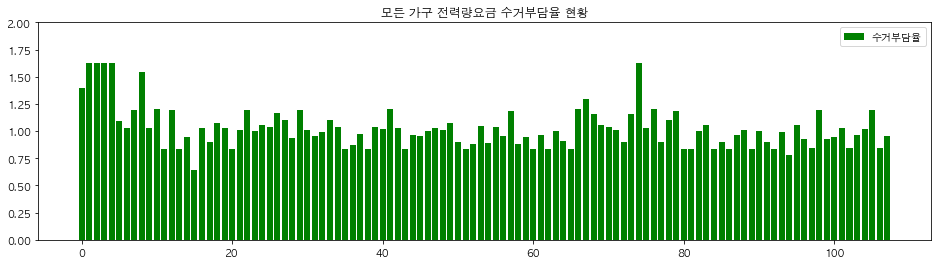

In [212]:
households_col = get_col_list(round(after_month_df['usage (kWh)'].mean()), calc.fee)
APT_col = get_col_list(round(after_APT / 108), calc.fee)
public_col = APT_col - households_col
public_mem = get_step_mem(public_col, calc.fee)

col_burden_list = list()

for usage in after_month_df['usage (kWh)']:
    chk_households_col = get_col_list(usage, calc.fee)
    _APT_mean = usage + public_col.sum()

    chk_APT_col = get_col_list(_APT_mean, calc.fee)
    chk_public_col = chk_APT_col - chk_households_col
    chk_public_mem = get_step_mem(chk_public_col, calc.fee)
    col_burden = public_mem / chk_public_mem
    
    col_burden_list.append(col_burden[-1])
    
plt.figure(figsize=(16,4))

plt.bar(range(len(col_burden_list)), col_burden_list, color='g', label='수거부담율')
plt.yticks(np.arange(0, 2.1, 0.25))
plt.title("모든 가구 전력량요금 수거부담율 현황")

plt.legend()

plt.show()

In [208]:
np.array(col_burden_list).std()

0.18941055325277814

# Recovery Feedback Pattern

패턴 복구 완료


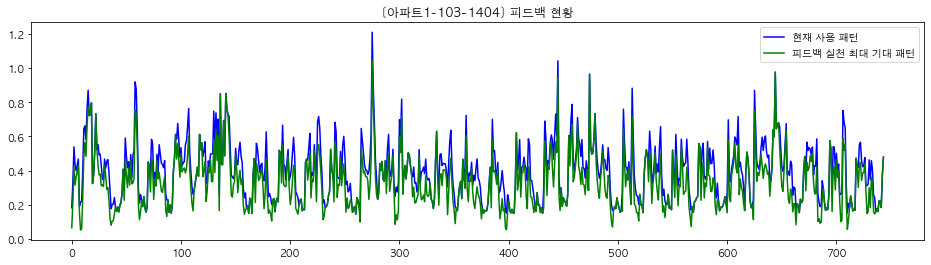

In [126]:
sv.recovery()

print("패턴 복구 완료")

ran_feedback = sv.group[sv.group['usage (kWh)'] != sv.new_group['usage (kWh)']].sample(n=1).copy()
name = ran_feedback['name'].values[0]
index = np.where(sv.datas.columns == name)[0][0]

plt.figure(figsize=(16,4))

plt.plot(sv.datas.values.T[index], label="현재 사용 패턴", color='b')
plt.plot(sv.recoveries[index], label="피드백 실천 최대 기대 패턴", color='g')
plt.title("[{}] 피드백 현황".format(name))

plt.legend(loc='upper right')
plt.show()

In [15]:
og_pat = sv.datas.values.T
rec_pat = sv.recoveries
err = (og_pat - rec_pat)
err[err != 0].min()

print(og_pat.shape, rec_pat.shape)
print("최소 오차", err[err != 0].min())

(108, 744) (108, 744)
최소 오차 0.0009999999999998899


In [146]:
sv = SavingFeedback(xlsx)
sv.select_month(1)

sv.kmeans_run()

# 3. adjust anomaly
sv.adjust_anomaly()
anomaly = sv.check_anomaly()
print("이상패턴 조정 확인", len(anomaly) == 0)

time_size = 4

sv.time_based_grouping(time_size)
sv.feedback()
sv.result()

time_group = sv.new_group.copy()
time_group.head()

print(round(time_group['usage (kWh)'].mean()))

sv.recovery()

ECV : 47 %
이상패턴 조정 확인 True
260


In [169]:
for idx,col in enumerate(sv.datas):
    sv.datas[col] = sv.recoveries[idx]

In [171]:
sv.kmeans_run()

# 3. adjust anomaly
sv.adjust_anomaly()
anomaly = sv.check_anomaly()
print("이상패턴 조정 확인", len(anomaly) == 0)

time_size = 4

sv.time_based_grouping(time_size)
sv.feedback()
sv.result()

time_group = sv.new_group.copy()
time_group.head()

print(round(time_group['usage (kWh)'].mean()))
sv.recovery()

ECV : 34 %
이상패턴 조정 확인 True
173


In [141]:
for idx,col in enumerate(sv.datas):
    sv.datas[col] = sv.recoveries[idx]

In [197]:
sv.kmeans_run()

# 3. adjust anomaly
sv.adjust_anomaly()
anomaly = sv.check_anomaly()
print("이상패턴 조정 확인", len(anomaly) == 0)

time_size = 4

sv.time_based_grouping(time_size)
sv.feedback()
sv.result()

time_group = sv.new_group.copy()
time_group.head()

print(round(time_group['usage (kWh)'].mean()))
sv.recovery()

ECV : 23 %
이상패턴 조정 확인 True
159


In [196]:
for idx,col in enumerate(sv.datas):
    sv.datas[col] = sv.recoveries[idx]

In [144]:
sv.kmeans_run()

# 3. adjust anomaly
sv.adjust_anomaly()
anomaly = sv.check_anomaly()
print("이상패턴 조정 확인", len(anomaly) == 0)

time_size = 4

sv.time_based_grouping(time_size)
sv.feedback()
sv.result()

time_group = sv.new_group.copy()
time_group.head()

print(round(time_group['usage (kWh)'].mean()))
sv.recovery()

ECV : 26 %
이상패턴 조정 확인 True
171


In [112]:
# 1. Data Pre-processing


# 2. KMeans Run
sv.kmeans_run()

# 3. adjust anomaly
sv.adjust_anomaly()
anomaly = sv.check_anomaly()
print("이상패턴 조정 확인", len(anomaly) == 0)

time_size = 4

sv.time_based_grouping(time_size)
sv.feedback()
sv.result()

time_group = sv.new_group.copy()
time_group.head()

round(time_group['usage (kWh)'].mean())

ECV : 47 %
이상패턴 조정 확인 True


257